In [2]:
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import glob
import cv2
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model, model_from_json
import matplotlib.pyplot as plt
import random
import matplotlib

In [3]:
input_au_noise = keras.Input(shape =(1,13), name = 'AU_occ_input_with_noise')
func_input = keras.Input(shape = (1,13), name = 'AU_input')
# input_au_noise = keras.Input(shape =(13), name = 'AU_occ_input_with_noise')
x = layers.Dense(13)(input_au_noise)
x = layers.LeakyReLU()(x)
x = layers.Dense(13)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(13)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(13, activation='sigmoid')(x)
corrected_au_values = layers.Multiply()([x, func_input])
classification_layer = layers.Dense(2, activation='sigmoid')(corrected_au_values)
vals = Model(inputs = (input_au_noise,func_input), outputs = corrected_au_values)
classification_model = keras.Model(inputs = (input_au_noise,func_input), outputs =classification_layer)


classification_model.load_weights('myweightsforclassification')

latent_dim = 50

image_input = keras.Input(shape = (128,128,1), name = 'image_input')
func_input = keras.Input(shape = (1,13), name = 'AU_input')


x = layers.Conv2D(filters=32, kernel_size=5, strides=(2,2), padding='same')(image_input)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=5, strides=(2,2), padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=128, kernel_size=5, strides=(2,2), padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=256, kernel_size=5, strides=(2,2), padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

img_encoded = layers.Dense(2*latent_dim, name = 'encoded_image')(x)

model_encoder = keras.Model(inputs = image_input, outputs = img_encoded)

discriminator_input = keras.Input(shape = (2*latent_dim), name = 'disc_input')

x = layers.LeakyReLU()(discriminator_input)

x = layers.Dense(latent_dim)(x)
x = layers.LeakyReLU()(x)

x = layers.Dense(latent_dim)(x)
x = layers.LeakyReLU()(x)

x = layers.Dense(latent_dim/2)(x)
x = layers.LeakyReLU()(x)
disc_output = layers.Dense(1,  name= 'disc_output')(x)

discriminator_for_normalization = keras.Model(inputs = discriminator_input, outputs = disc_output)


flattened_au = layers.Flatten()(func_input)
combined_input = layers.concatenate([img_encoded, flattened_au])


x = layers.Dense(1024)(combined_input)

x = layers.Dense(1024)(x)

x = layers.Dense(16384)(x)
x = layers.Reshape((8,8,256))(x)
x = layers.Conv2DTranspose(filters=256, kernel_size=5, strides=(2,2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=5, strides=(2,2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(filters=64, kernel_size=5, strides=(2,2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(filters=32, kernel_size=5, strides=(2,2), padding='same')(x)
x = layers.LeakyReLU()(x)

output_img= layers.Conv2DTranspose(filters = 1, kernel_size =5, strides= (1,1), padding = 'same', name = 'output_image')(x)

#model_decoder = keras.Model(inputs = combined_input, outputs = output_img )

total_discriminator_input = keras.Input(shape = (128,128,1), name= 'image_input_for_disc')
x = layers.LeakyReLU()(total_discriminator_input)

x = layers.Flatten()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(latent_dim)(x)
x = layers.LeakyReLU()(x)

x = layers.Dense(latent_dim)(x)
x = layers.LeakyReLU()(x)

x = layers.Dense(latent_dim/2)(x)
x = layers.LeakyReLU()(x)
disc_output_real_or_fake = layers.Dense(1,  name= 'disc_output_real_fake')(x)

total_discriminator = keras.Model(inputs = total_discriminator_input, outputs = disc_output_real_or_fake)



model_AE = keras.Model(inputs = [image_input, func_input], outputs = output_img)



model_AE.load_weights('AE_weights')

In [4]:
def au_output_from_classifier(au):
    AU_input = np.array(au).reshape(-1,1,13).astype('float32')
    noise = tf.random.uniform((1,13), minval = 0.5, maxval = 1)
    AU_and_noise = np.array(au*noise).reshape(-1,1,13)
    pred_au = vals.predict((AU_and_noise, AU_input))
    AV = classification_model.predict((AU_and_noise, AU_input))
    return pred_au, AV


def generate_image(input_image, aus):
    aus = np.array(aus).reshape(-1,1,13)
    input_image = np.array(input_image).reshape(-1,128,128,1)
    gen_image = model_AE.predict([input_image, aus])
    
    return gen_image

# we start with sad expression low arousal and low valence

[[[0.55143154 0.26771042]]]


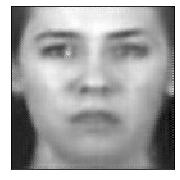

In [5]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [1, 0, 1, 0, 0, 0, 0,  0,   0,  1,  0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.56960154 0.28095844]]]


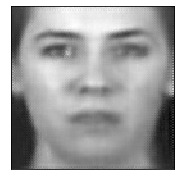

In [6]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [.51, 0, .51, 0, 0, 0, 0,  0,   0,  .51,  0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)



image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.5870309  0.29070926]]]


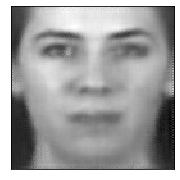

In [7]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, .0, 0, .0, 0, 0,  0,   0,  0,  0,  .0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.60349756 0.29752403]]]


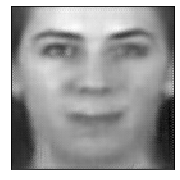

In [8]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [-.51, 0, -.51, 0, 0, 0, 0,  0,   0,  -.51,  0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.6183945  0.30367216]]]


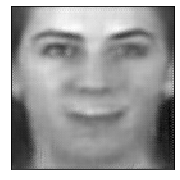

In [9]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [-1, 0, -1, 0, 0, 0, 0,  0,   0,  -1,  0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

# Going in negative direction of sad expression by negating values in AU_OCC vector we transform it to happy expression high arousal and valence

# Here we go for disgust expression slightly higher arousal and very low valence 

[[[0.59786916 0.10911433]]]


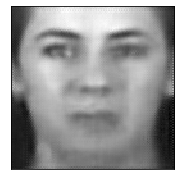

In [10]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 0, 0, 0, 1.9, 0,  0,   0,  1.97,0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.5925728  0.18130207]]]


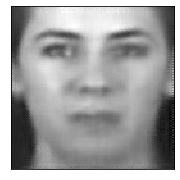

In [11]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 0, 0, 0, 1.0, 0,  0,   0,  1.0,0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.5898022  0.23198582]]]


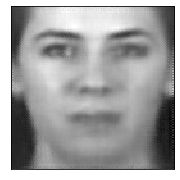

In [12]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 0, 0, 0, .51, 0,  0,   0,  .51, 0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.5883964  0.26044124]]]


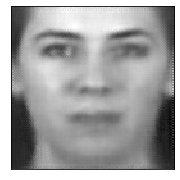

In [13]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 0, 0, 0, .251, 0,  0,   0,  .251,  0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.58716667 0.28757605]]]


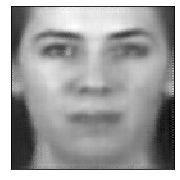

In [14]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 0, 0, 0, .0251, 0,  0,   0,  .0251,  0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.5870309  0.29070926]]]


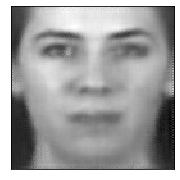

In [15]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 0, 0, 0, .0, 0,  0,   0,  .0,  0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.5844042  0.35807988]]]


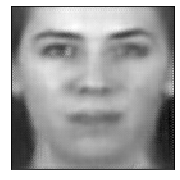

In [16]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 0, 0, 0, -.50, 0,  0,   0,  -.50, 0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.5794979 0.5167508]]]


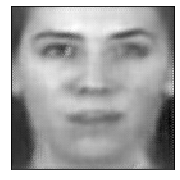

In [17]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 0, 0, 0, -1.50, 0,  0,   0,  -1.50, 0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.57792735 0.59028864]]]


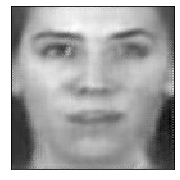

In [18]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 0, 0, 0, -1.90, 0,  0,   0,  -1.90, 0,  0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

# Here first image for disgust expression has positive values added to AU_OCC and then with each image the AU_OCC values are lowered and last image has negative values for AU_OCC vector that give slightly low arousal and very high valence

# Here we take anger expression high arousal and low valence

[[[0.6667443 0.1917677]]]


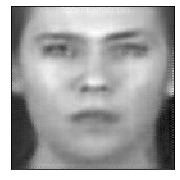

In [19]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 1.5, 0, 1.5, 0, 0,  0,   0,  0, 0,  1.5,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.63726    0.22399138]]]


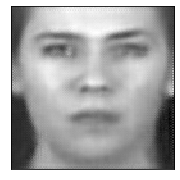

In [20]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 1., 0, 1., 0, 0,  0,   0,  0, 0,  1.,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.6113536  0.25879017]]]


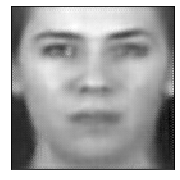

In [21]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, .5, 0, .5, 0, 0,  0,   0,  0, 0,  .5,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.6115261 0.2579056]]]


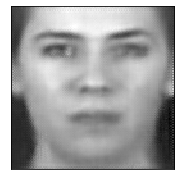

In [22]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, .5, 0, .5, 0, 0,  0,   0,  0, 0,  .5,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.5870309  0.29070926]]]


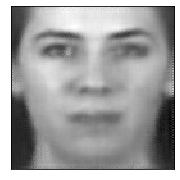

In [23]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, 0.0, 0, .0, 0, 0,  0,   0,  0, 0,  .0,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.56438553 0.32243124]]]


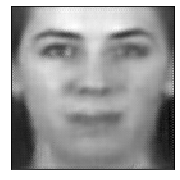

In [24]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, -.5, 0, -.5, 0, 0,  0,   0,  0, 0,  -.5,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.54493064 0.34479916]]]


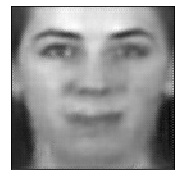

In [25]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, -1., 0, -1., 0, 0,  0,   0,  0, 0,  -1.,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

[[[0.5231103 0.3703356]]]


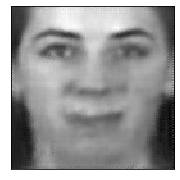

In [26]:
gu = [1, 2, 4, 6, 7, 9, 10, 12, 14, 15, 17, 23, 24]

au = [0, 0, 0, 0, 0, 0, 0,  0,   0,  0,  0,  0,  0]

au = [0, 0, -1.5, 0, -1.5, 0, 0,  0,   0,  0, 0,  -1.5,  0]

k,AV = au_output_from_classifier(au)

print(AV)
#print(k)


image = cv2.imread('F:\MSProject\graphsfromclassifier/1104.png',0)/255.0

image_pred = generate_image(image,k)
plt.figure(figsize=(3,3))

plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(image_pred.reshape(128,128),  cmap='gray')
plt.show()

# In the first image positive values are added to first AU_OCC vector and subsequently the values are reduced till the last image where AU_OCC vector has negative values and thus classifies as low arousal and high valence